# Gradient-based multislice ptychography with Jax

In [1]:
%config InlineBackend.rc = {"figure.dpi": 150, "figure.figsize": (12.0, 8.0)}
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".15"

import asyncio
import abtem
import ase
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tqdm.auto as tqdm
from abtem.multislice import FresnelPropagator
from jax_multislice import transmission_function, get_frequencies, FresnelPropagator as propagate, shift_kernel

abtem.config.set({"device": "cpu"});


## Structure + Potential

First build a structure to simulate and reconstruct, for `MoS2` I stretch the unit cell in the z-direction to give more propagation between the slices.

In [2]:
atoms = ase.build.mx2(vacuum=0.8)
atoms.set_cell(atoms.cell * np.asarray([1, 1, 8]), scale_atoms=True)


In [3]:
atoms = abtem.orthogonalize_cell(atoms)
atoms *= (3, 2, 1)

Choose a slice thickness to acheive one slice-per-layer:

In [4]:
potential = abtem.Potential(
    atoms,
    sampling=0.2,
    slice_thickness=15,
)
potential_array = potential.build(lazy=False).array
print(potential.shape)

(3, 48, 56)


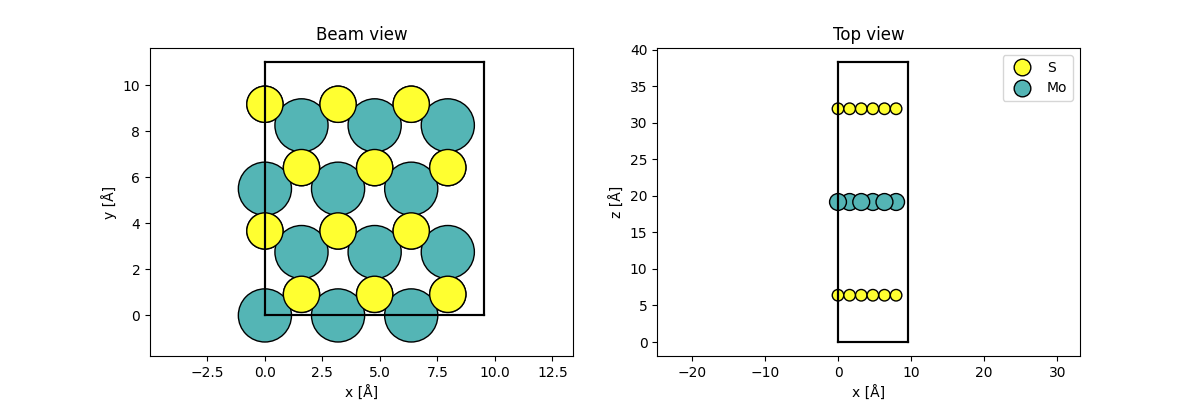

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True);

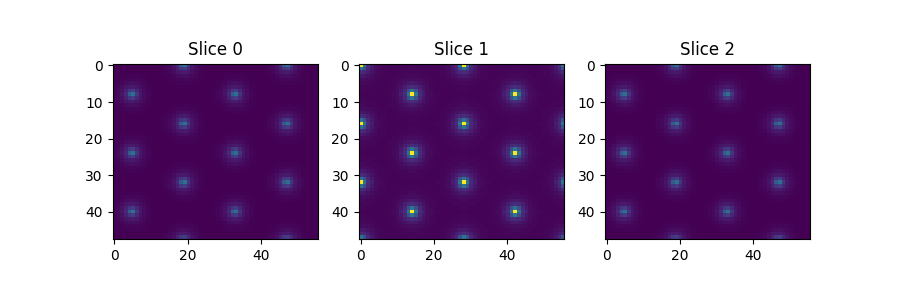

In [6]:
rows = int(np.floor(np.sqrt(len(potential_array))))
cols = int(np.ceil(np.sqrt(len(potential_array))))
if rows * cols < len(potential_array):
    cols += 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
vmin = potential_array.min()
vmax = potential_array.max()
for i, (p, s_ax) in enumerate(zip(potential_array, ax.ravel())):
    s_ax.imshow(p, vmin=vmin, vmax=vmax)
    s_ax.set_title(f"Slice {i}")

## Probe

In [7]:
energy = 200e3
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=40,
    defocus=40,
    Cs=1e2,
    trefoil=1e2,
    trefoil_angle=np.pi/7,
    coma=5e2,
)
probe.grid.match(potential)
probe.shape

(48, 56)

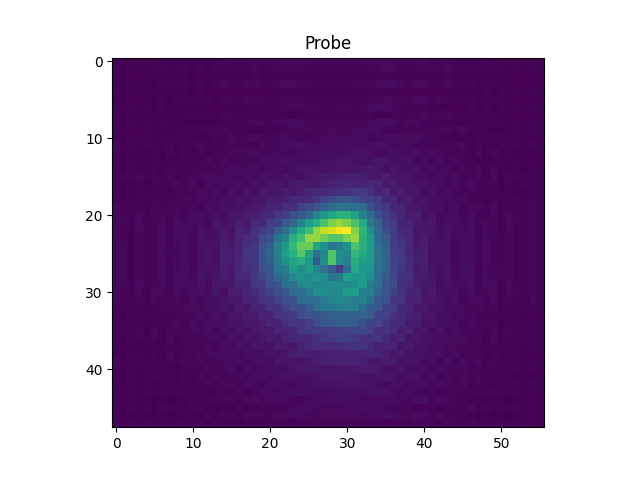

In [8]:
fig, ax = plt.subplots()
ax.imshow(np.abs(probe.build(lazy=False).array))
ax.set_title('Probe');

## Scan grid

In [9]:
grid_scan = abtem.GridScan(
    # start=(0.3, 0.3),
    # end=(0.7, 0.7),
    end=(1, 1),
    fractional=True,
    sampling=probe.aperture.nyquist_sampling * 2,
    potential=potential,
)
scan_positions = jnp.array(grid_scan.get_positions())
grid_scan.shape

(31, 36)

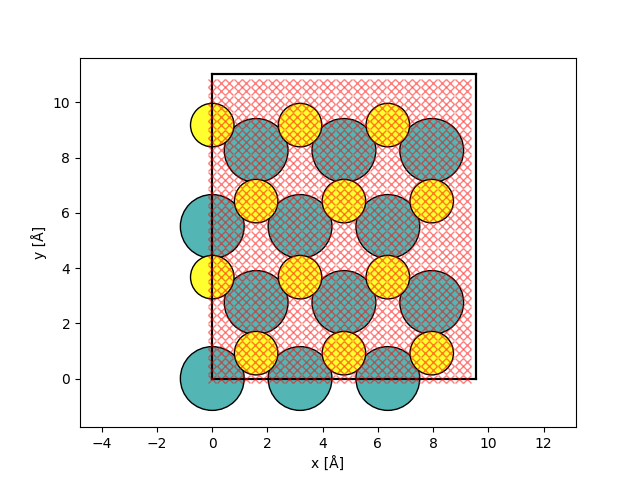

In [10]:
fig, ax = abtem.show_atoms(atoms)
scan_pos_flat = scan_positions.reshape(-1, 2)
ax.plot(scan_pos_flat[:, 0], scan_pos_flat[:, 1], 'rx', alpha=0.5);

## Generate diffraction patterns

In [11]:
detector = abtem.PixelatedDetector(max_angle='full')
measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=detector,
)
abtem_patterns = measurements.compute().array
abtem_patterns.shape

[########################################] | 100% Completed | 304.15 ms


(31, 36, 48, 56)

## Check forward model

Build the forward model so as to return the shifted probe, exit wave and diffraction pattern for testing purposes

In [12]:
def simulate_pattern_test(slices, probe_shift, probe_fft, energy, prop_kernel, frequencies):
    transmission = transmission_function(slices, energy)
    probe_shifted = jnp.fft.ifft2(
        probe_fft * shift_kernel(*probe_shift, *frequencies)
    )
    wavefront = probe_shifted
    
    for i in range(slices.shape[0]):
        wavefront = wavefront * transmission[i]
        wavefront = propagate(wavefront, prop_kernel)
    
    exit_wave = wavefront
    
    diffraction_pattern = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(diffraction_pattern.real)
        + jnp.square(diffraction_pattern.imag)
    )
    
    return probe_shifted, exit_wave, diffraction_pattern

Forward model inputs:

In [13]:
slice_thickness = jnp.array(potential.slice_thickness[0])
sampling = jnp.array(potential.sampling)

slices = jnp.array(potential_array)
probe_00 = probe.build(scan=abtem.CustomScan(positions=(0, 0)), lazy=False)
probe_fft = jnp.fft.fft2(probe_00.array)

Fx, Fy = get_frequencies(slices.shape[-2:], sampling)
prop_abtem = FresnelPropagator().get_array(probe_00, float(slice_thickness))

Check the forward model against abTEM at a given scan grid position

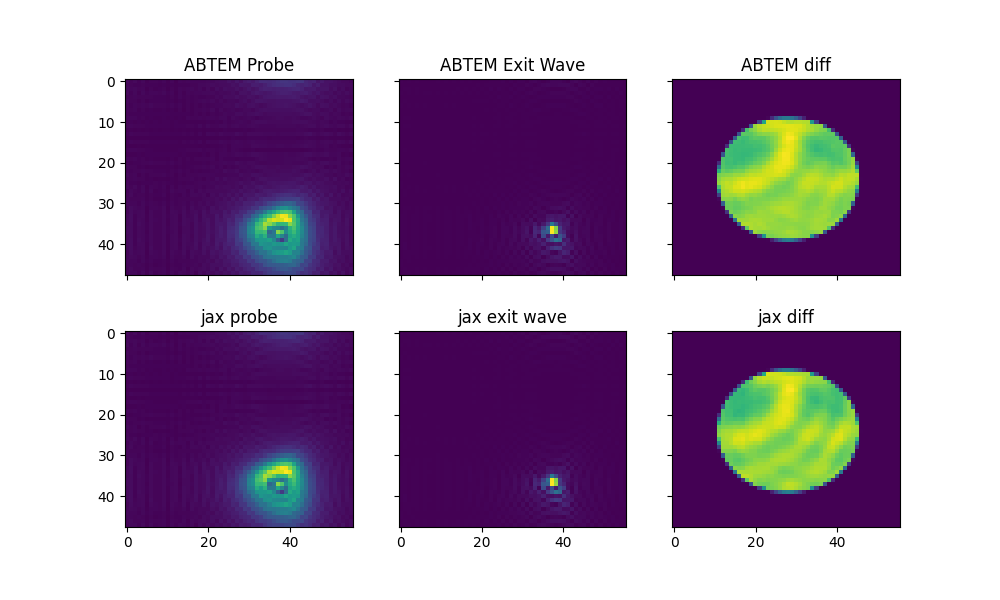

In [14]:
gx, gy = scan_positions.shape[:2]
idx_x, idx_y = 3 * gx // 4, 2 * gy  // 3
plot_scan = abtem.CustomScan(scan_positions[idx_x, idx_y])

plot_exit_wave = probe.scan(
    potential,
    scan=plot_scan,
    detectors=abtem.WavesDetector()
).compute(progress_bar=False).array.squeeze()
plot_probe = probe.build(scan=plot_scan).compute(progress_bar=False).array.squeeze()

jax_probe_shifted, jax_exit_wave, jax_pattern = simulate_pattern_test(
    slices,
    scan_positions[idx_x, idx_y],
    probe_fft,
    energy,
    prop_abtem,
    (Fx, Fy),
)

fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
ax = ax.T.ravel()
ax[0].imshow(np.abs(plot_probe))
ax[0].set_title('ABTEM Probe')
ax[1].imshow(np.abs(jax_probe_shifted))
ax[1].set_title('jax probe')
ax[2].imshow(np.abs(plot_exit_wave))
ax[2].set_title('ABTEM Exit Wave')
ax[3].imshow(np.abs(jax_exit_wave))
ax[3].set_title('jax exit wave')
ax[4].imshow(np.abs(abtem_patterns[idx_x, idx_y]))
ax[4].set_title('ABTEM diff')
ax[5].imshow(np.abs(jax_pattern))
ax[5].set_title('jax diff');

There are still some residual differences between abTEM and Jax diffraction patterns, to be explored:

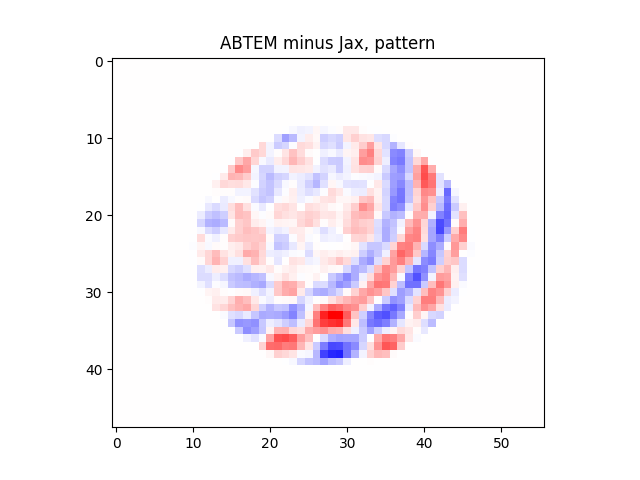

In [15]:
fig, ax = plt.subplots()
difference = abtem_patterns[idx_x, idx_y] - jax_pattern
vmax = np.abs(difference).max()
ax.imshow(difference, vmin=-vmax, vmax=vmax, cmap="bwr")
ax.set_title('ABTEM minus Jax, pattern');

## Inverse multislice

Build the forward model again but in a slightly more optimised way for the fitting process (and JIT it)

In [16]:
def simulate_pattern(slices, probe_shifted, prop_kernel):
#     probe_shifted = jnp.fft.ifft2(
#         probe_fft * shift_kernel(*scan_position, Fx, Fy)
#     )
    wavefront = probe_shifted
    
    for i in range(slices.shape[0]):
        wavefront = wavefront * slices[i]
        wavefront = propagate(wavefront, prop_kernel)
    
    diffraction_pattern = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(diffraction_pattern.real)
        + jnp.square(diffraction_pattern.imag)
    )
    return diffraction_pattern

simulate_pattern_jit = jax.vmap(jax.jit(simulate_pattern), in_axes=(None, 0, None))

Loss function for the fitting against the abTEM diffraction pattern. Use the L2 loss of the pattern, plus a term forcing the object to have unit amplitude:

In [17]:
def loss(abtem_pattern, slices, probe, prop_kernel):
    jax_pattern = simulate_pattern_jit(slices, probe, prop_kernel)
    return (
        jnp.mean(
            optax.l2_loss(jax_pattern, abtem_pattern)
        )
    )

loss_jit = jax.jit(loss)

Pick the number of reconstruction slices and generate the inputs to the forward model:

In [49]:
num_slices_recon = 3
shape = (num_slices_recon, *slices.shape[-2:])
opt_slices = jnp.ones(shape, dtype=jnp.complex64)
recon_slice_thickness = float(sum(potential.slice_thickness) / num_slices_recon)

# Use the abTEM propagator, needs to match the slice thickness in the reconstruction
prop_abtem = FresnelPropagator().get_array(probe_00, recon_slice_thickness)

# Rather than re-compute the shifted probe each iteration use abTEM to give us all the probes
all_probes = probe.build(scan=grid_scan, lazy=False).array
all_probes_flat = jnp.array(all_probes.reshape(-1, *all_probes.shape[-2:]), dtype=jnp.complex64)

We can choose to optimise against abTEM's diffration patterns or patterns generated with the forward model:

In [56]:
target_patterns, target_name = simulate_pattern_jit(transmission_function(slices, energy), all_probes_flat, prop_abtem), "abtem"
# target_patterns, target_name = abtem_patterns.reshape(-1, *abtem_patterns.shape[-2:]), "j-forward"
target_patterns.shape

(1116, 48, 56)

Initialize the optimiser. Contrary to typical use of ADAM this problem can accept a very high initial learning rate.

In [51]:
learning_rate = 1e1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_slices)
losses = []

Create a plot which will be updated during iteration with the loss value.

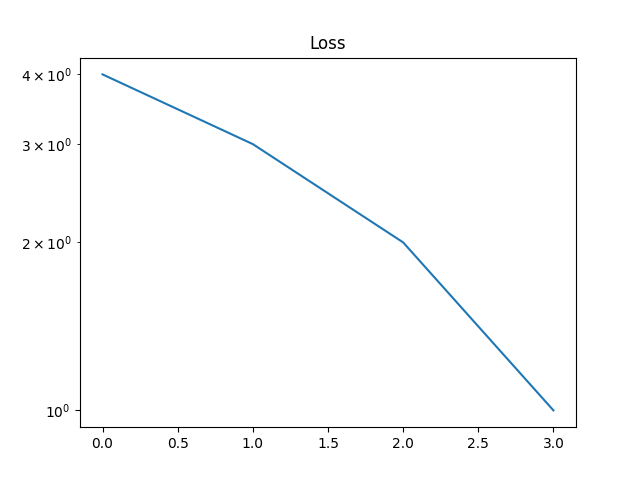

In [52]:
fig, ax = plt.subplots()
loss_plot = ax.plot(np.arange(1, 5)[::-1])[0]
ax.set_title("Loss");
ax.set_yscale("log")

In [53]:
# This is necessary to let the above plot initialize
await asyncio.sleep(0.5)

Run reconstruction over randomised batches of diffraction patterns (`chunksize` at a time), for a total of `num_epochs` passes over the data.

In [54]:
num_epochs = 1_000  # number of passes through the dataset
chunksize = 256  # number of patterns used to compute an update step

iteration_idxs = np.arange(len(scan_pos_flat))
num_patterns = len(iteration_idxs)
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)
chunks = chunks[:-1]  # skip the last chunk as it may be incomplete, which will add a periodic spike in the loss, not an issue as we are shuffling
assert len(chunks) > 0, "Chunksize is too large for this dataset"

num_iterations = len(chunks) * num_epochs
ax.set_xlim(0, num_iterations)
loss_plot.set_xdata(np.arange(num_iterations))
losses = np.full((num_iterations,), np.nan)

iteration = 0
for epoch in (outer_pbar := tqdm.trange(num_epochs)):
    np.random.shuffle(iteration_idxs)
    for scan_pos_idx in chunks:
        loss_val, grads = jax.value_and_grad(loss_jit, argnums=1)(
            target_patterns[iteration_idxs[scan_pos_idx]],
            opt_slices,
            all_probes_flat[iteration_idxs[scan_pos_idx]],
            prop_abtem,
        )
        # Conjugating the gradients is necessary in Jax, we are not sure why
        grads = jnp.conjugate(grads)
        updates, opt_state = optimizer.update(grads, opt_state)
        opt_slices = optax.apply_updates(opt_slices, updates)
        losses[iteration] = loss_val
        iteration += 1
    if (epoch % 10) == 0:
        outer_pbar.set_description(f"Loss {losses[max(0, iteration - 20):iteration].mean(): .3e}")
        loss_plot.set_ydata(losses)
        ax.set_ylim(0.1 * losses[:iteration].min(), 1.1 * losses[:iteration].max())
        sl_update = jnp.abs(updates[0])
        fig.canvas.draw()

  0%|          | 0/1000 [00:00<?, ?it/s]

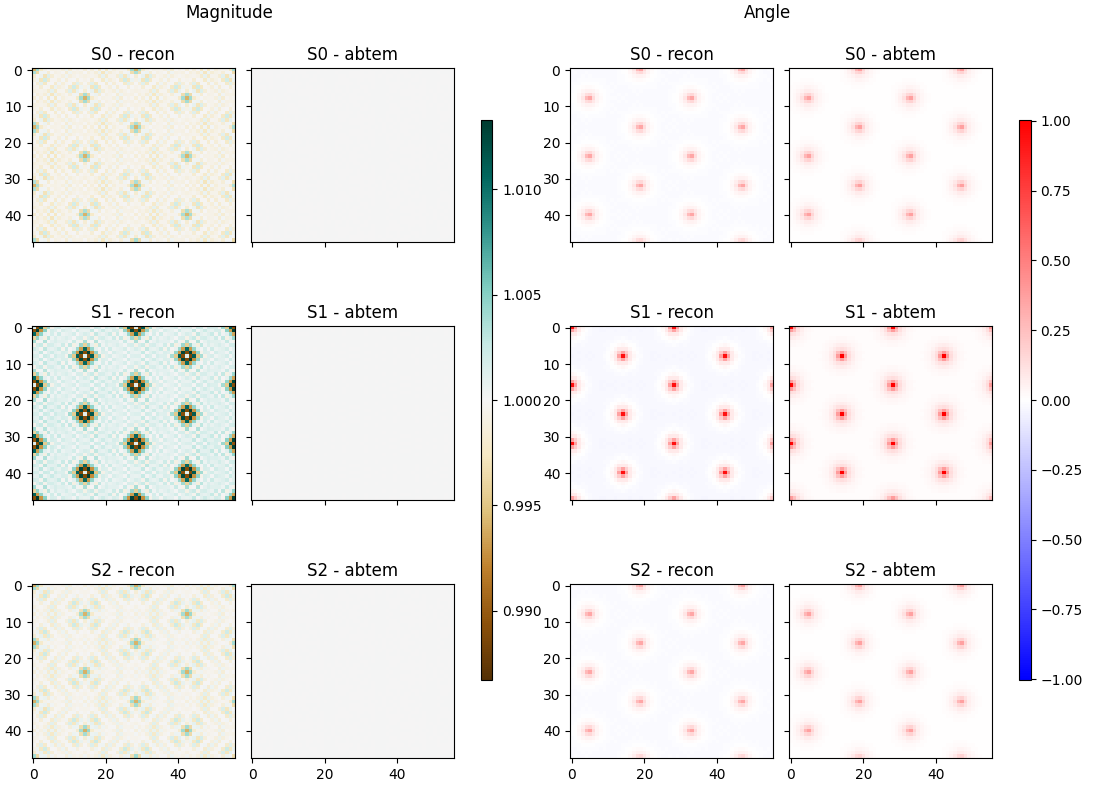

In [55]:
transmit = transmission_function(slices, energy)

fig = plt.figure(layout="constrained", figsize=(11, 8))
subfigs = fig.subfigures(1, 3, wspace=0.22, width_ratios=[1, 1, 0.05])

axs = subfigs[0].subplots(num_slices_recon, 2, sharex=True, sharey=True)
# a_min = min(np.abs(opt_slices).min(), np.abs(transmit).min())
# a_max = max(np.abs(opt_slices).max(), np.abs(transmit).max())
a_max = max(np.abs((np.abs(opt_slices) - 1)).max(), np.abs((np.abs(transmit) - 1)).max())
ang_max = max(np.abs(np.angle(opt_slices)).max(), np.abs(np.angle(transmit)).max())


for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_slices, transmit, axs)):
    im_abs = ax1.imshow(np.abs(recon_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.abs(abtem_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax2.set_title(f"S{i} - {target_name}")
subfigs[0].suptitle("Magnitude")
cbar_ax = subfigs[0].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[0].colorbar(im_abs, cax=cbar_ax)

num_slices_potential = transmit.shape[0]
axs = subfigs[1].subplots(num_slices_potential, 2, sharex=True, sharey=True)
for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_slices, transmit, axs)):
    im_ang = ax1.imshow(np.angle(recon_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.angle(abtem_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax2.set_title(f"S{i} - {target_name}")
subfigs[1].suptitle("Angle");
cbar_ax = subfigs[1].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[1].colorbar(im_ang, cax=cbar_ax)